In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import scanpy as sc
import scvi
import sc_utils
#import scrublet as scr
warnings.filterwarnings('ignore')

In [ ]:
import torch

In [ ]:
torch.cuda.device_count()

In [2]:
def get_markers(adata,groupby,key="rank_genes_groups",p_val_cutoff=0.05,logfc_cutoff=0.5):
    """\
    Extract markers from adata into Seurat-like table
    Extracts markers after they are computed by ``scanpy``. Produces Seurat-like
    table with fields
    ``"p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"``
    Calculates the percentage of cells that express a given gene
    in the target cluster (``pct.1`` field) and outside the cluster
    (``pct.2`` field) from ``adata.raw`` matrix.
    Parameters
    ----------
    adata
        Annotated data matrix.
    groupby
        ``adata.obs`` field used for marker calculation
    key
        ``adata.uns`` key that has computed markers
    p_val_cutoff
        Drop all genes with adjusted p-value greater than or equal to this
    logfc_cutoff
        Drop all genes with average logFC less than or equal to this
    Returns
    -------
    Returns a pandas dataframe with above listed columns, optionally
    subsetted on the genes that pass the cutoffs.
    ``p_val`` field is a copy of adjusted p-value field.
    Example
    -------
    >>> sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", n_genes=200)
    >>> markers = sc_utils.get_markers(adata, "leiden")
    >>> markers.to_csv("markers.csv")
    """
    markers = pd.concat([
        pd.DataFrame(adata.uns[key]["names"]).melt(),
        pd.DataFrame(adata.uns[key]["pvals_adj"]).melt(),
        pd.DataFrame(adata.uns[key]["logfoldchanges"]).melt()
    ], axis=1)
    markers.columns = ("cluster", "gene", "cluster2", "p_val_adj", "cluster3", "avg_logFC")
    markers = markers.loc[:, ["cluster", "gene", "avg_logFC", "p_val_adj"]]
    markers = markers.loc[markers.avg_logFC > logfc_cutoff, ]
    markers = markers.loc[markers.p_val_adj < p_val_cutoff, ]
    markers["pct.1"] = pd.Series(dtype=float)
    markers["pct.2"] = pd.Series(dtype=float)
    for cluster in markers.cluster.unique():
        cells = adata.obs[groupby] == cluster
        in_cluster_selector = markers.cluster == cluster
        genes = markers.gene[in_cluster_selector]
        in_cluster = np.sum(adata.raw[cells, genes].X > 0, axis=0) / cells.sum()
        markers.loc[in_cluster_selector, "pct.1"] = in_cluster.T.A1
        other_cells = adata.obs[groupby] != cluster
        other_clusters = np.sum(adata.raw[other_cells, genes].X > 0, axis=0) / other_cells.sum()
        markers.loc[in_cluster_selector, "pct.2"] = other_clusters.T.A1
    markers["p_val"] = markers.p_val_adj
    markers = markers.loc[:, ["p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"]]
    return markers
    
# cr_dir = '/projects/b1038/Pulmonary/sfenske/sequencing/data/2024-4/cellranger'
# adata_sets = []
# for s in os.listdir(cr_dir):
#     if not s.endswith('.csv'):
#         sample_adata = sc.read_10x_h5(
#             f'{cr_dir}/{s}/outs/filtered_feature_bc_matrix.h5')
#         sample_adata.var_names_make_unique()
#         sample_adata.obs['sample_id'] = s
#         sample_adata.var['MT'] = sample_adata.var_names.str.startswith('MT-')
#         sample_adata.var['ribo'] = sample_adata.var_names.str.startswith(('RPS','RPL'))
#         try:
#             scrub = scr.Scrublet(sample_adata.X)
#             doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=True)
#             sample_adata.obs['doublet_scores'] = doublet_scores
#             sample_adata.obs['predicted_doublets'] = predicted_doublets
#         except:
#             print(f"error for {s}",flush=True)
#             sample_adata.obs['doublet_scores'] = 0
#             sample_adata.obs['predicted_doublets'] = False
#         adata_sets.append(sample_adata)
# adata = adata_sets[0].concatenate(adata_sets[1:],join='outer')

# adata.var.index = [x.split('GRCh38______')[1] if 'GRCh38______' in x else x for x in adata.var.index]
# adata.var.gene_ids = [x.split('GRCh38______')[1] if 'GRCh38______' in x else x for x in adata.var.gene_ids]
# adata.var['ensembl_id'] = adata.var['gene_ids']
# adata.var['gene_ids'] = adata.var.index
# adata.var['MT'] = adata.var_names.str.startswith('MT-')
# adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))
# sc.pp.calculate_qc_metrics(adata,qc_vars=['MT','ribo'],percent_top=[10,20],log1p=False,inplace=True)

# # for scArches
# adata.obs['sample'] = adata.obs['sample_id']

    
adata = sc.read_h5ad('../data/10x_PBMC.h5ad')

FOLDER = '../data/PBMC_9_4_2024'
OBJ_NAME = 'PBMC_integrated'
BATCH_VARIABLE = 'library_id'

adata.layers['counts'] = adata.X
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

sc.pp.highly_variable_genes(adata,subset=True,n_top_genes=2000,batch_key=BATCH_VARIABLE,flavor='seurat_v3',layer='counts')

param_set = {"n_layers":2,"n_hidden":256,"dropout_rate":0.2,"n_latent":10}
scvi.data.setup_anndata(adata,layer="counts",batch_key=BATCH_VARIABLE)
# vae = scvi.model.SCVI.load(f"../DeepSeq_1113_vae_2000", adata)

vae = scvi.model.SCVI(adata,**param_set)

train_kwargs = {
    "early_stopping": True,
    "early_stopping_monitor": "reconstruction_loss_validation",
    "early_stopping_patience": 25
}
vae.train(max_epochs=400,**train_kwargs)
vae.save(f"../code/{OBJ_NAME}",overwrite=True)


latent_adata = vae.get_latent_representation()
adata.obsm["X_scVI"] = latent_adata
adata.layers["scvi_normalized"] = vae.get_normalized_expression(library_size=10e4)
sc.pp.neighbors(adata,use_rep='X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata,key_added="leiden_scVI")

adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata, "leiden_scVI", method="wilcoxon", n_genes=200)
markers = get_markers(adata,'leiden_scVI')

for col in adata.obs.columns:
    if adata.obs[col].dtype == 'category':
        adata.obs[col] = adata.obs[col].astype('str')


if not os.path.isdir(FOLDER):
    os.mkdir(FOLDER)
markers.to_csv(f'{FOLDER}/{OBJ_NAME}-markers.csv')
adata.obs.to_csv(f'{FOLDER}/{OBJ_NAME}-metadata.csv')
adata.write_h5ad(f'{FOLDER}/{OBJ_NAME}.h5ad')


INFO     Using batches from adata.obs["library_id"]                                                                
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 29976 cells, 2000 vars, 4 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 106/400:  26%|██▋       | 106/400 [03:59<11:04,  2.26s/it, loss=309, v_num=1]


In [3]:
adata


AnnData object with n_obs × n_vars = 29976 × 2000
    obs: 'library_id', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'total_counts_MT', 'pct_counts_MT', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene_ids', 'feature_types', 'genome', 'ensembl_id', 'MT', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi', 'neighbors', 'umap', 'leiden', 'rank_genes_groups'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [4]:
sc.pp.neighbors(adata, use_rep = "X_scVI")

In [5]:
sc.tl.leiden(adata, resolution = 0.3)

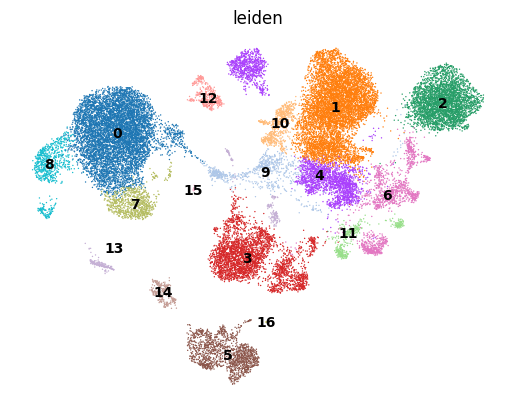

In [6]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")


In [7]:
adata.obs

,library_id,batch,n_genes_by_counts,total_counts,pct_counts_in_top_10_genes,pct_counts_in_top_20_genes,total_counts_MT,pct_counts_MT,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var,leiden_scVI,leiden
AAACCAAAGCGTTACA-1-0,5p_GEM_X_10K_PBMC,0,4000,17626.0,12.526949,20.140701,0.0,0.0,0.0,0.0,2,0,5.509009,0.136385,2,2
AAACCAAAGGCTGGAA-1-0,5p_GEM_X_10K_PBMC,0,6045,35020.0,9.948601,15.171331,0.0,0.0,0.0,0.0,2,0,5.509009,0.136385,4,0
AAACCAAAGGTATCCA-1-0,5p_GEM_X_10K_PBMC,0,3995,17742.0,12.061774,18.791568,0.0,0.0,0.0,0.0,2,0,5.509009,0.136385,1,1
AAACCAGCAATAGCAG-1-0,5p_GEM_X_10K_PBMC,0,4132,17379.0,13.148052,19.535071,0.0,0.0,0.0,0.0,2,0,5.509009,0.136385,2,2
AAACCCATCAATCTGG-1-0,5p_GEM_X_10K_PBMC,0,3878,14828.0,10.743189,16.118155,0.0,0.0,0.0,0.0,2,0,5.509009,0.136385,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGCTATTG-1-3,3p_NextGEM_5K_PBMC,3,2883,8053.0,11.548491,16.701850,0.0,0.0,0.0,0.0,1,0,5.590536,0.113746,10,4
TTTGTTGCATATGCGT-1-3,3p_NextGEM_5K_PBMC,3,3034,9464.0,13.736264,20.054945,0.0,0.0,0.0,0.0,1,0,5.590536,0.113746,7,5
TTTGTTGCATCCGAAT-1-3,3p_NextGEM_5K_PBMC,3,3656,10766.0,8.740479,12.493034,0.0,0.0,0.0,0.0,1,0,5.590536,0.113746,22,13
TTTGTTGCATTGAGGG-1-3,3p_NextGEM_5K_PBMC,3,1755,3553.0,11.849142,16.802702,0.0,0.0,0.0,0.0,1,0,5.590536,0.113746,0,0


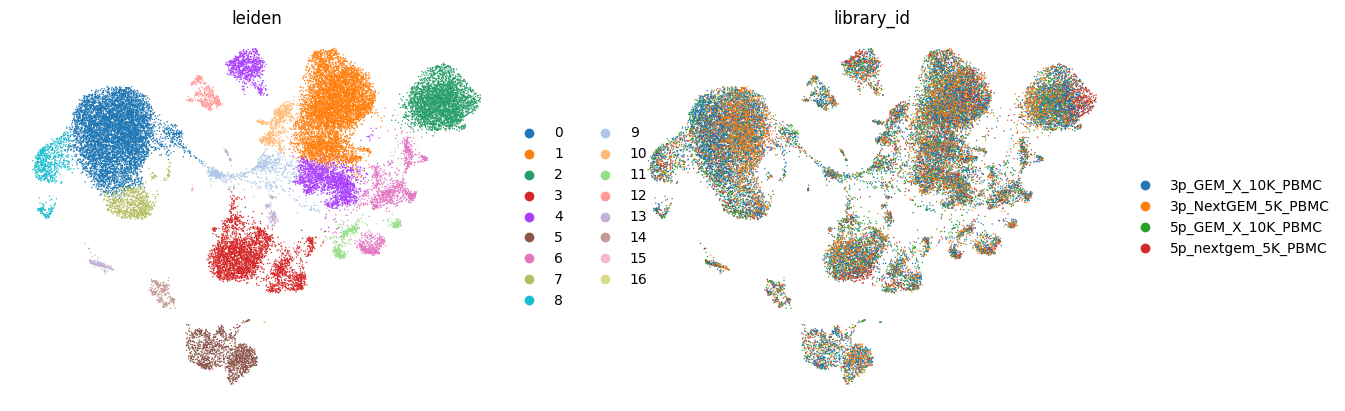

In [8]:
sc.pl.umap(adata, color = ['leiden', 'library_id'], frameon = False)

In [9]:
sc.tl.rank_genes_groups(adata, 'leiden')


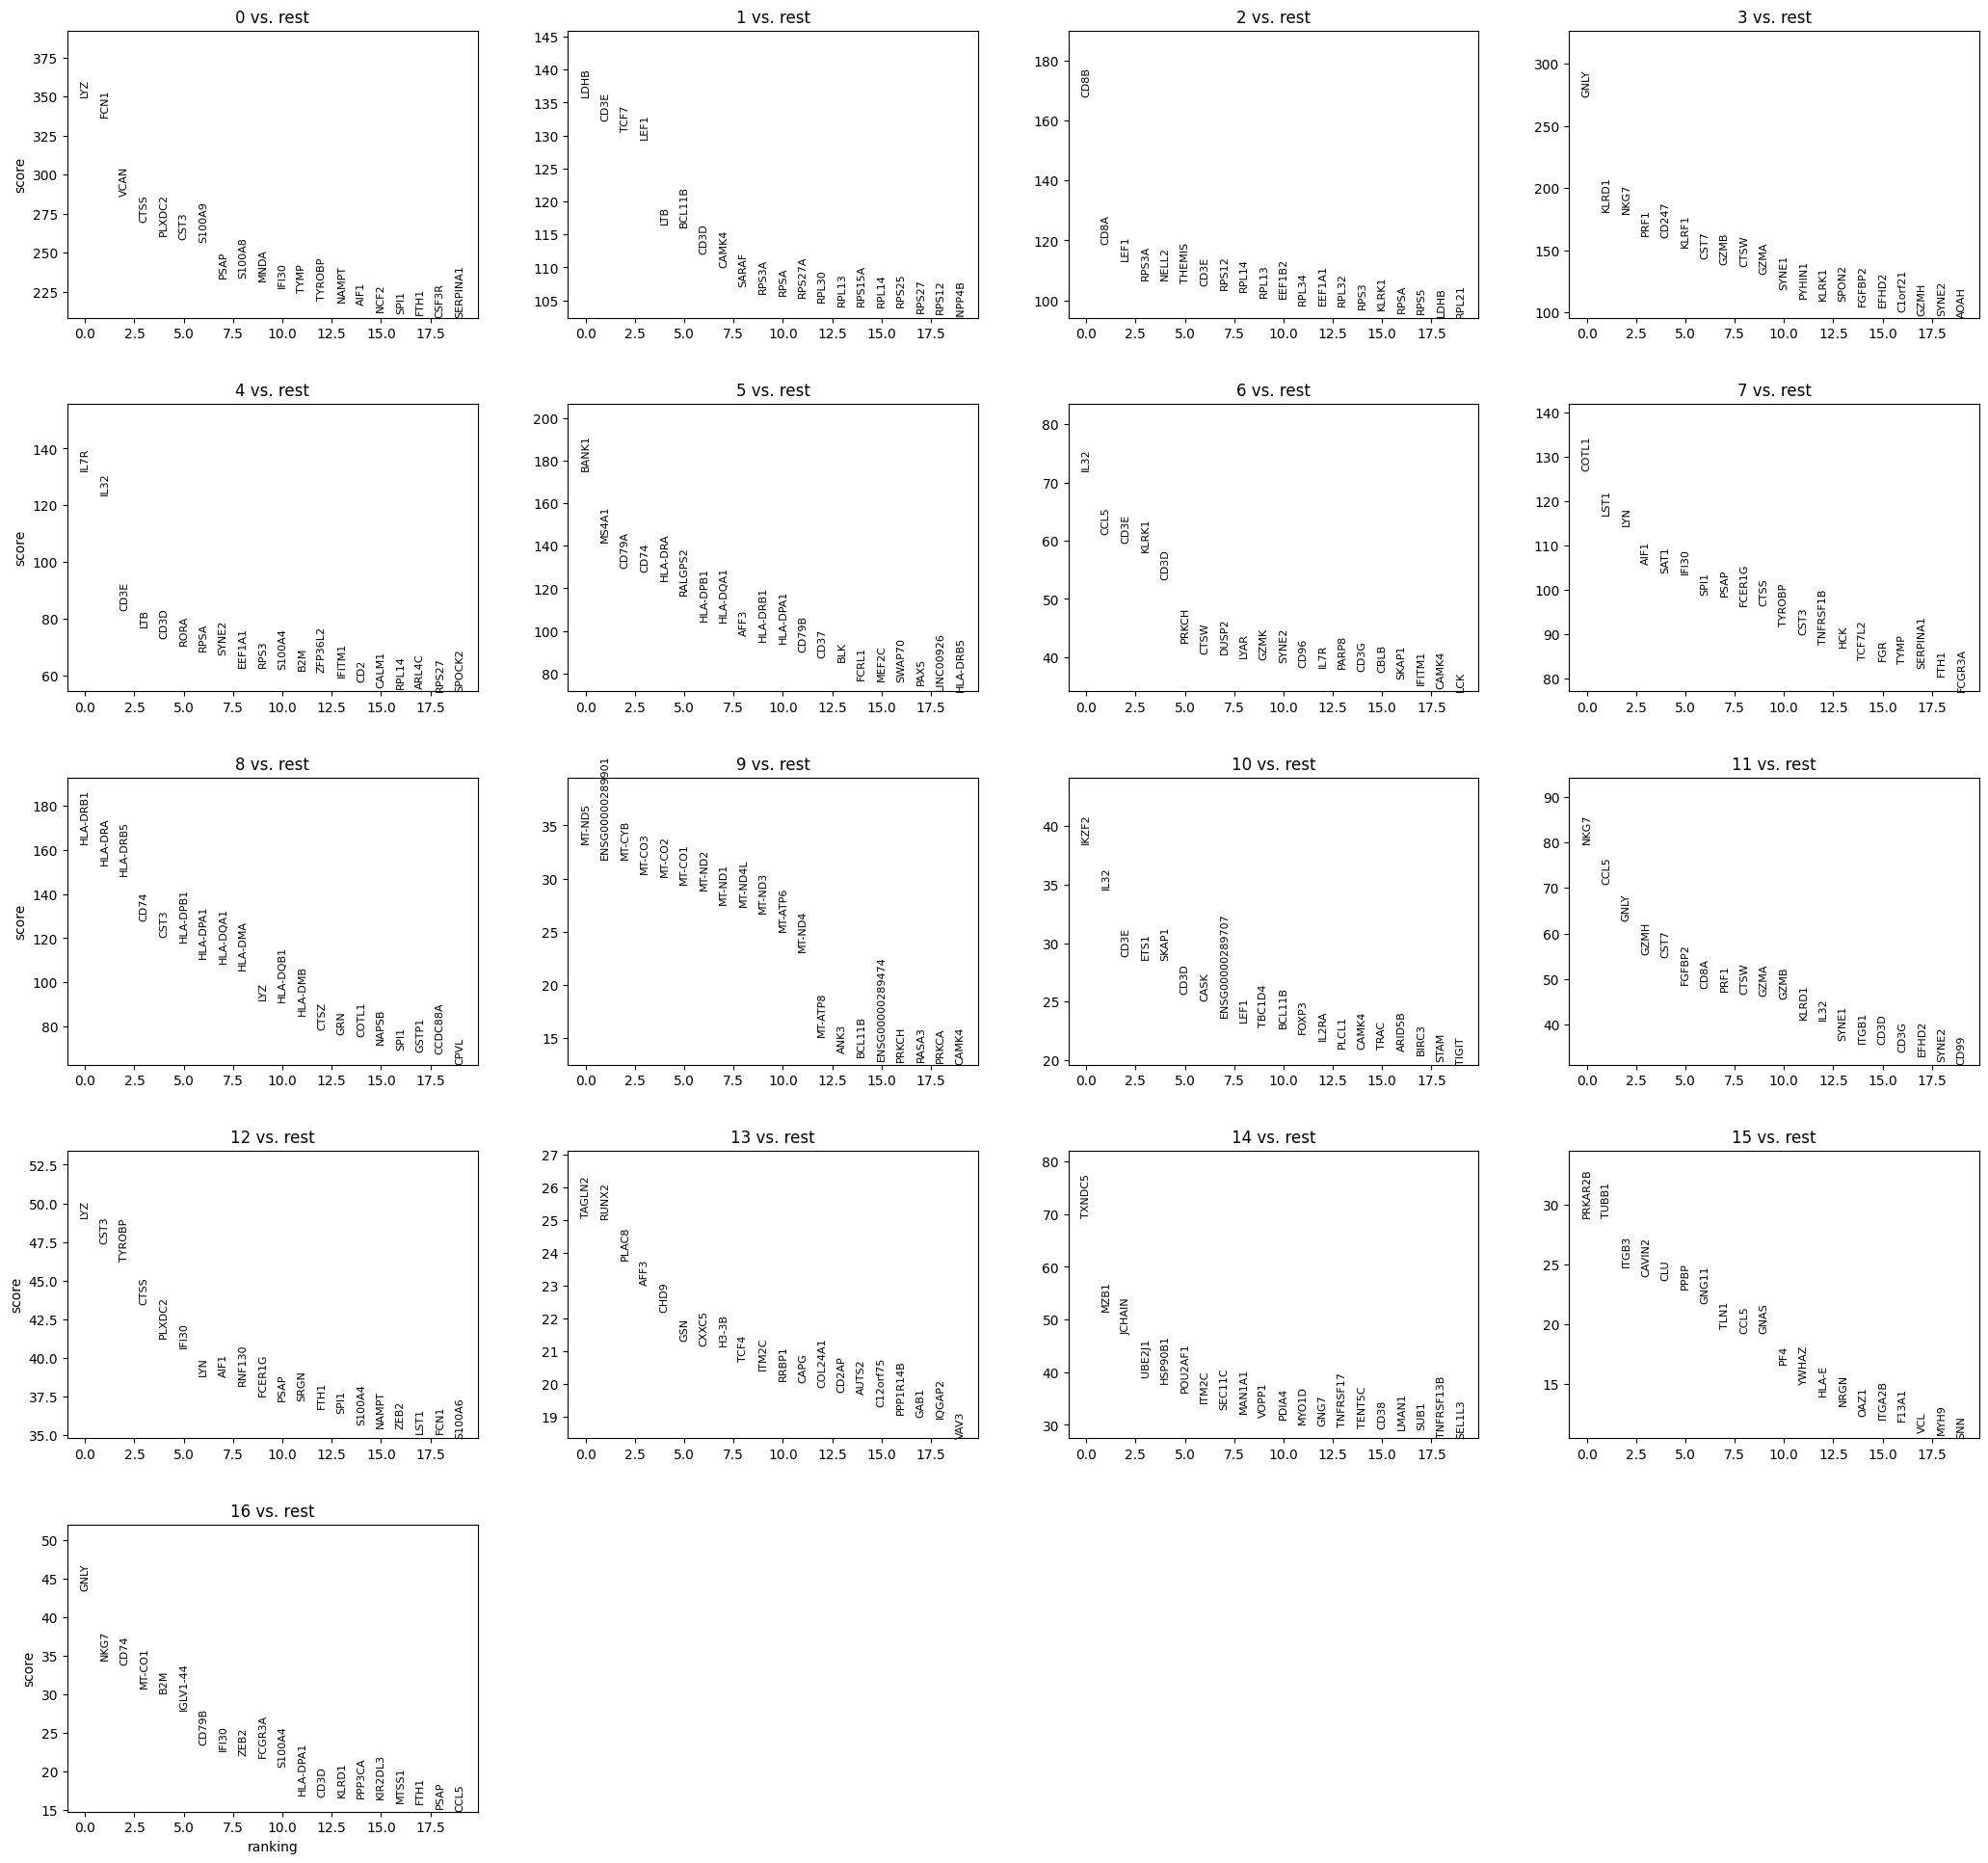

In [10]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [11]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,LYZ,349.860809,6.794613,0.0,0.0
1,0,FCN1,337.277740,6.020815,0.0,0.0
2,0,VCAN,286.093201,6.908425,0.0,0.0
3,0,CTSS,269.526672,4.244068,0.0,0.0
4,0,PLXDC2,261.140625,5.289322,0.0,0.0
...,...,...,...,...,...,...
656297,16,EDEM3,-129.942673,-28.522451,0.0,0.0
656298,16,WASHC2C,-137.969666,-28.619961,0.0,0.0
656299,16,ENSG00000289474,-146.031219,-31.346603,0.0,0.0
656300,16,TTC19,-146.070923,-28.812315,0.0,0.0


In [12]:
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,LYZ,349.860809,6.794613,0.000000,0.000000
1,0,FCN1,337.277740,6.020815,0.000000,0.000000
2,0,VCAN,286.093201,6.908425,0.000000,0.000000
3,0,CTSS,269.526672,4.244068,0.000000,0.000000
4,0,PLXDC2,261.140625,5.289322,0.000000,0.000000
...,...,...,...,...,...,...
618351,16,NDUFB2,3.247288,0.641026,0.022656,0.049145
618352,16,CLN3,3.243005,2.123463,0.022861,0.049548
618354,16,JAK1,3.237707,0.525233,0.022892,0.049602
618355,16,DCAF7,3.237573,1.315025,0.022976,0.049768


In [13]:
markers_scvi = vae.differential_expression(groupby = 'leiden')
markers_scvi

DE...: 100%|██████████| 17/17 [00:19<00:00,  1.12s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PELATON,0.9960,0.0040,5.517450,0.000654,0.000144,0.0,0.25,6.561866,6.663184,3.343700,...,0.282609,0.058930,0.459775,0.050391,7.037042,1.622409,True,0 vs Rest,0,Rest
ETS1,0.9958,0.0042,5.468460,0.000059,0.007329,0.0,0.25,-6.850948,-7.060866,1.832372,...,0.039298,1.582098,0.099625,0.872309,0.965189,73.021591,True,0 vs Rest,0,Rest
ENSG00000255801,0.9956,0.0044,5.421739,0.000039,0.000001,0.0,0.25,5.593081,5.627496,1.986884,...,0.019597,0.000300,0.039360,0.000738,0.489484,0.007538,True,0 vs Rest,0,Rest
ABLIM1,0.9952,0.0048,5.334326,0.000014,0.004840,0.0,0.25,-8.116325,-8.511215,2.598512,...,0.009532,0.868571,0.025375,0.671701,0.235375,41.510612,True,0 vs Rest,0,Rest
PYHIN1,0.9950,0.0050,5.293303,0.000008,0.002140,0.0,0.25,-7.213570,-7.726526,3.240007,...,0.006291,0.575413,0.016436,0.413194,0.156386,23.026495,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AOAH,0.6628,0.3372,0.675797,0.005787,0.004891,0.0,0.25,0.667095,0.130087,1.317197,...,1.996848,1.457267,1.000000,0.734501,47.442638,49.659252,False,16 vs Rest,16,Rest
BCAS3,0.6448,0.3552,0.596259,0.002153,0.002249,0.0,0.25,0.057715,0.068858,0.589487,...,0.802538,0.668791,1.000000,0.607441,19.080845,24.772793,False,16 vs Rest,16,Rest
ADGRE5,0.6018,0.3982,0.412971,0.003155,0.003268,0.0,0.25,0.057442,-0.004913,0.601967,...,1.194219,0.856713,0.833333,0.705272,28.326412,30.916685,False,16 vs Rest,16,Rest
PTK2B,0.5818,0.4182,0.330167,0.002201,0.002532,0.0,0.25,-0.119639,-0.094068,0.487297,...,1.051408,0.707727,0.833333,0.632065,25.004379,24.269337,False,16 vs Rest,16,Rest


In [14]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
PELATON,0.9960,0.0040,5.517450,0.000654,0.000144,0.0,0.25,6.561866,6.663184,3.343700,...,0.282609,0.058930,0.459775,0.050391,7.037042,1.622409,True,0 vs Rest,0,Rest
ENSG00000255801,0.9956,0.0044,5.421739,0.000039,0.000001,0.0,0.25,5.593081,5.627496,1.986884,...,0.019597,0.000300,0.039360,0.000738,0.489484,0.007538,True,0 vs Rest,0,Rest
TMEM158,0.9940,0.0060,5.109976,0.000030,0.000005,0.0,0.25,5.291648,5.473024,1.917540,...,0.013361,0.001034,0.034314,0.001606,0.326533,0.041700,True,0 vs Rest,0,Rest
CD14,0.9938,0.0062,5.076985,0.004753,0.000239,0.0,0.25,6.133041,6.689163,2.411367,...,1.870528,0.073210,0.942907,0.089149,46.429787,2.352069,True,0 vs Rest,0,Rest
S100A12,0.9938,0.0062,5.076985,0.003326,0.000157,0.0,0.25,6.137913,6.353889,2.659891,...,1.418366,0.046878,0.871684,0.062023,35.333572,1.625407,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000273181,0.8938,0.1062,2.130158,0.000002,0.000002,0.0,0.25,0.813742,0.851617,1.657000,...,0.000000,0.000256,0.000000,0.000367,0.000000,0.010661,True,16 vs Rest,16,Rest
CPB2,0.8936,0.1064,2.128053,0.000002,0.000003,0.0,0.25,0.520492,0.394935,1.962188,...,0.000000,0.000721,0.000000,0.001101,0.000000,0.023885,True,16 vs Rest,16,Rest
NDST3,0.8932,0.1068,2.123853,0.000004,0.000007,0.0,0.25,0.520284,0.433208,1.996432,...,0.000000,0.001602,0.000000,0.002269,0.000000,0.076686,True,16 vs Rest,16,Rest
CNNM3-DT,0.8932,0.1068,2.123853,0.000004,0.000005,0.0,0.25,0.663212,0.535107,1.940369,...,0.000000,0.001257,0.000000,0.001935,0.000000,0.056774,True,16 vs Rest,16,Rest


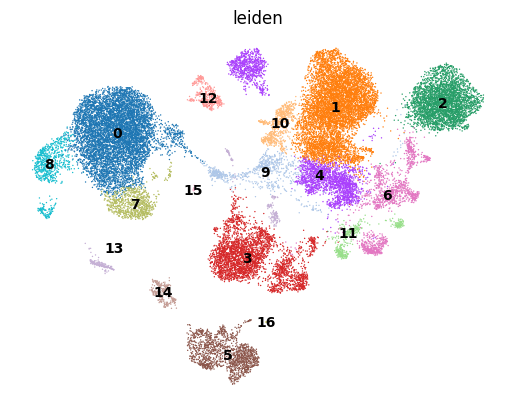

In [15]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

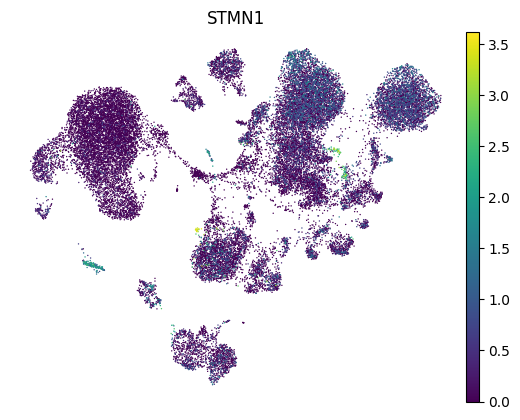

In [16]:
sc.pl.umap(adata, color = ['STMN1'], frameon = False)
           #layer = 'scvi_normalized', vmax = 10)

In [17]:
markers[markers.names == 'CD4']

,group,names,scores,logfoldchanges,pvals,pvals_adj
675,0,CD4,64.614235,1.512490,0.000000e+00,0.000000e+00
38870,1,CD4,37.260715,0.988504,7.706618e-286,2.026714e-284
271036,7,CD4,19.902292,1.085641,5.535215e-73,1.096421e-71
309553,8,CD4,17.690254,0.967300,2.607745e-59,5.668616e-58
386315,10,CD4,7.997733,0.643896,6.026317e-15,6.909771e-14
464023,12,CD4,11.376306,0.784291,4.372292e-26,1.962752e-24
503102,13,CD4,6.239599,0.909298,1.314803e-09,1.216082e-08


In [18]:
markers_scvi[markers_scvi.group1 =='6']

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
TRGV2,0.9918,0.0082,4.795386,0.000596,0.000039,0.0,0.25,8.639063,8.891666,4.603320,...,0.151350,0.012023,0.142251,0.011378,6.738347,0.504006,True,6 vs Rest,6,Rest
XCL1,0.9878,0.0122,4.394043,0.000347,0.000031,0.0,0.25,6.508336,6.991725,4.282589,...,0.093889,0.012093,0.095541,0.011273,3.882463,0.444513,True,6 vs Rest,6,Rest
GZMK,0.9876,0.0124,4.377580,0.005309,0.000484,0.0,0.25,7.270730,7.719578,3.851632,...,1.368293,0.128151,0.631989,0.077968,55.836506,5.224500,True,6 vs Rest,6,Rest
TRGV4,0.9876,0.0124,4.377580,0.000209,0.000015,0.0,0.25,5.274162,5.399804,3.005697,...,0.057555,0.003781,0.059448,0.004691,2.510062,0.161904,True,6 vs Rest,6,Rest
ZNF683,0.9872,0.0128,4.345427,0.001255,0.000078,0.0,0.25,6.605890,7.016510,4.091138,...,0.217375,0.017594,0.183298,0.016700,9.265686,0.673296,True,6 vs Rest,6,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000182376,0.9328,0.0672,2.630517,0.000009,0.000005,0.0,0.25,0.875981,0.822775,3.020120,...,0.001809,0.001100,0.002123,0.001926,0.074962,0.039885,True,6 vs Rest,6,Rest
ENSG00000248545,0.9328,0.0672,2.630517,0.000011,0.000007,0.0,0.25,0.726493,0.756518,3.146644,...,0.002171,0.000668,0.002831,0.001085,0.093112,0.026690,True,6 vs Rest,6,Rest
ENSG00000257256,0.9328,0.0672,2.630517,0.000020,0.000009,0.0,0.25,1.875165,1.700922,2.509196,...,0.001799,0.000898,0.001415,0.001085,0.070162,0.038640,True,6 vs Rest,6,Rest
DIAPH3,0.9328,0.0672,2.630517,0.000102,0.000036,0.0,0.25,1.550395,1.518912,2.237975,...,0.019401,0.008581,0.025478,0.011238,0.825186,0.342523,True,6 vs Rest,6,Rest


In [19]:
#reference used: http://cells.ucsc.edu/?ds=covid19-immuno+all&cell=Severe_P09_CTAAGACCAACTGCGC&gene=LILRA4

In [20]:
for x in range(0,16):
    print(f'"{x}":"",')
for x in range(0,16):
    print(f'"{x} marker used":"",')

"0":"",
"1":"",
"2":"",
"3":"",
"4":"",
"5":"",
"6":"",
"7":"",
"8":"",
"9":"",
"10":"",
"11":"",
"12":"",
"13":"",
"14":"",
"15":"",
"0 marker used":"",
"1 marker used":"",
"2 marker used":"",
"3 marker used":"",
"4 marker used":"",
"5 marker used":"",
"6 marker used":"",
"7 marker used":"",
"8 marker used":"",
"9 marker used":"",
"10 marker used":"",
"11 marker used":"",
"12 marker used":"",
"13 marker used":"",
"14 marker used":"",
"15 marker used":"",


In [ ]:
"0":"CD14+ Monocyte",
"1":"T",
"2":"CD8 T",
"3":"",
"4":"NK",
"5":"B",
"6":"T", continue to work on this
"7":"CD16+ Monocyte",
"8":"",
"9":"",
"10":"",
"11":"CD8 T",
"12":"",
"13":"DC",
"14":"Plasma",
"15":"Platelet",
"0 marker used":"FCN1",
"1 marker used":"CD3E",
"2 marker used":"CD3E, CD8A",
"3 marker used":"",
"4 marker used":"'CTSW', 'CST7'",
"5 marker used":"CD79A",
"6 marker used":"TRGV2",
"7 marker used":"IFITM3",
"8 marker used":"",
"9 marker used":"",
"10 marker used":"",
"11 marker used":",CD3E, CD8A",
"12 marker used":"",
"13 marker used":"LILRA4",
"14 marker used":"MZB1",
"15 marker used":"PPBP",
